# EDA
### Author: Yuxing Zhou
### Date: Sep 12

## Referenced Kernels and Other Links:
https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px

https://www.kaggle.com/smoschou55/advanced-eda-brain-tumor-data/comments#Main-Competition-Workflow

https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling

https://www.kaggle.com/ayuraj/brain-tumor-eda-and-interactive-viz-with-w-b

https://case.edu/med/neurology/NR/MRI%20Basics.htm

https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data

https://www.kaggle.com/sreevishnudamodaran/rsna-3d-clahe-voxels-tpu-3d-augmentations

# Table of Contents
### 1. Make sense of provided data & files
### 2. Check for corrupted/weird data
### 3. Visualize data of positive / negative cases
### 4. Explore the data in 3D
### 5. Explore ways to align images / center-crop / other augmentation
### 6. My opinion on the ultimate goal of this competition

## Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
from tensorflow import keras
import sys
import random
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from IPython.display import IFrame
from IPython.core.display import display, HTML
import imageio

from mpl_toolkits import mplot3d
import seaborn as sns
from tqdm import tqdm
from itertools import chain
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import callbacks

import matplotlib
matplotlib.rcParams['animation.html'] = 'jshtml'
from PIL import Image
import cv2
import glob
import re
import random
from scipy import ndimage, misc

import time
import cv2
import pydicom
from multiprocessing import Pool
from matplotlib.animation import FuncAnimation
print(tf.__version__)
print(keras.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Print 10 filesname just to see what it looks like

In [ ]:
allInputs = os.walk('/kaggle/input')
# print(type(walking)) #<class 'generator'>
count = 0
for root, dirs, filenames in allInputs:
    for filename in filenames:
        count+=1
        if(count > 10):
            break
        print(os.path.join(root, filename))
    if(count > 10):
        break

## Global Configurations

In [ ]:
!pwd

In [ ]:
config = {
    'data_path': '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification',
    'train_data_path': '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train',
    'test_data_path': '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test',
    'input_path': '/kaggle/input'
}

# Folder Stucture and Simple Counting
**In this section, we will go through:**

**1. illustrating the folder structure of training data folder**

**2. Quick note on the level of balance of input data**

**3. try sort the paths stored in a random folder of images**

**4. find out if there are any potential problems in the filenames of these images**

**5. find out whether the images are named strictly consecutively**

### Define a Helper Function to print out structured files

In [ ]:
# Adapted a brilliant code snippet from StackOverFlow:
# https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python

# This function will print the first five sub-folders / sub files inside the parameter "startpath"
def list_files(startpath, num):
    masterCount = 0
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        masterCount += 1
        if(masterCount >= 12):
            break
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        count = 0
        for f in files:
            count += 1
            if(count> num):
                break
            print('{}{}'.format(subindent, f))

In [ ]:
list_files(config['train_data_path'],3)

In [ ]:
train_df = pd.read_csv(os.path.join(config['data_path'],'train_labels.csv'))
print("Total number of training data points (number of patient cases): ", len(train_df))
train_df.head()

**All the labels(MGMT_value) are 0 and 1**

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(data=train_df, x="MGMT_value");

**We can see that the distribution is quite balanced.**

**Note this: having a 0 MGMT_value doesn't mean there is no tumor!!!**

## Can we trust the integrity and organization of the images in each subfolder of each patient?
**Iterate through the whole folder structure and check for problems**

**Using tqdm to show the progress**

### Define a Helper Function

This is directly adapted from this brilliant kernel https://www.kaggle.com/mikecho/rsna-miccai-monai-ensemble/notebook

In [ ]:
# I did not write this
def natural_sort(li): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key=alphanum_key)

**Note that: filesnames in folders can be continuous even if they don't start at "Image-1.dcm". It happens several times throughout the dataset.**

**For example: "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00547/T2w/Image-258.dcm" was the first image in that folder... weird.**

In [ ]:
imgFolders = glob.glob(config['train_data_path']+"*/*/*")
for i in range(5):
    print(imgFolders[i])

print("Do we have four sub-folders per case?:")
print(len(imgFolders) == 4*len(train_df))
for folder in tqdm(imgFolders):
    filenames = glob.glob(folder+"/*")
    flag = True
    for filename in natural_sort(filenames):
        assert "Image-" in filename and ".dcm" in filename
        if(flag):
            count = int(filename[7+len(folder):-4])
            flag = False
#         print(filename[7+len(folder):-4])
        if(count == int(filename[7+len(folder):-4])):
            count += 1
        else:
            print("there was a discontinuity, no file: "+filename)
            break
        
# for (root, dirs, filenames) in tqdm(os.walk(config['train_data_path'])):
# #     print(root)
#     count = 0
#     print(root)
#     for filename in filenames:
#         count +=1
#         if(count>2):
#             break
#         print(os.path.join(root, filename))
    

### There are indeed discontinuities in the filenames!!
**For now, I will skip these. We will revisit them later after having defined a good image loader for DICOM images**

# Data Loader and Pre-processor

## DICOM MetaData

**Here we try to find out whether there are any useful metadata**

**This code snippets is adapted from Peter's post https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/252942**

#### Three axis to take the MRI scans below:

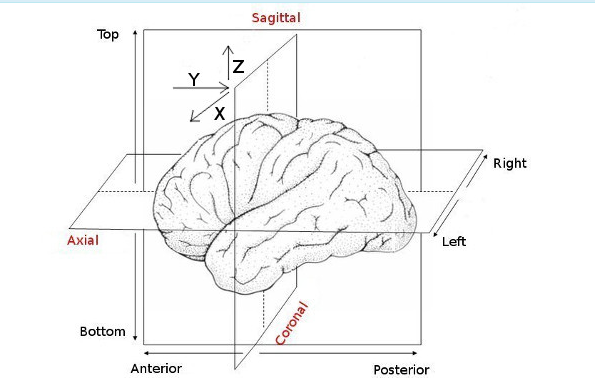

In [ ]:
args={}
args['input'] = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
args['output'] = './'
args['dataset'] = 'train'
args['n_jobs'] = 20
args['debug'] = 0


FIELDS = [
    'AccessionNumber',
    'AcquisitionMatrix',
#    'B1rms',  # Empty
#    'BitsAllocated',  # = 16
#    'BitsStored',  # = 16
    'Columns',
    'ConversionType',
#    'DiffusionBValue',  # 0 or empty
#    'DiffusionGradientOrientation',  # [0.0, 0.0, 0.0] or empty
    'EchoNumbers',
#    'EchoTime',  # empty
    'EchoTrainLength',
    'FlipAngle',
#    'HighBit',  # = 15
#    'HighRRValue',  #  0 or empty
    'ImageDimensions',  # 2 or epty
    'ImageFormat',
    'ImageGeometryType',
    'ImageLocation',
    'ImageOrientation',
    'ImageOrientationPatient',
    'ImagePosition',
    'ImagePositionPatient',
#    'ImageType',  # ['DERIVED', 'SECONDARY']
    'ImagedNucleus',
    'ImagingFrequency',
    'InPlanePhaseEncodingDirection',
    'InStackPositionNumber',
    'InstanceNumber',
#    'InversionTime',   # empty
#    'Laterality',  # empty
#    'LowRRValue',  # empty
    'MRAcquisitionType',
    'MagneticFieldStrength',
#    'Modality',  # MR
    'NumberOfAverages',
    'NumberOfPhaseEncodingSteps',
    'PatientID',
    'PatientName',
#    'PatientPosition',  # HFS
    'PercentPhaseFieldOfView',
    'PercentSampling',
#    'PhotometricInterpretation',  # MONOCHROME2
    'PixelBandwidth',
#    'PixelPaddingValue',  # empty or 0
    'PixelRepresentation',
    'PixelSpacing',
#    'PlanarConfiguration',  # 0 or empty
#    'PositionReferenceIndicator',  # 'NA' or empty
    'PresentationLUTShape',
    'ReconstructionDiameter',
#    'RescaleIntercept',  # = 0
#    'RescaleSlope',  # = 1
#    'RescaleType',  # = US
    'Rows',
    'SAR',
    'SOPClassUID',
    'SOPInstanceUID',
#    'SamplesPerPixel',  # = 1
    'SeriesDescription',
    'SeriesInstanceUID',
    'SeriesNumber',
    'SliceLocation',
    'SliceThickness',
    'SpacingBetweenSlices',
    'SpatialResolution',
    'SpecificCharacterSet',
    'StudyInstanceUID',
#    'TemporalResolution',  # 0 or empty
#    'TransferSyntaxUID',  # = 1.2.840.10008.1.2
#    'TriggerWindow',  # = 0
    'WindowCenter',
    'WindowWidth'
]

# All of the FM fields are empty
FM_FIELDS = [
    'FileMetaInformationGroupLength',
    'FileMetaInformationVersion',
    'ImplementationClassUID',
    'ImplementationVersionName',
    'MediaStorageSOPClassUID',
    'MediaStorageSOPInstanceUID',
    'SourceApplicationEntityTitle',
    'TransferSyntaxUID',
]

final = []


def get_meta_info(dicom):
    row = {f: dicom.get(f) for f in FIELDS}
    row_fm = {f: dicom.file_meta.get(f) for f in FM_FIELDS}
    row_other = {
#        'is_original_encoding': dicom.is_original_encoding,  # = True
#        'is_implicit_VR': dicom.is_implicit_VR,  # = True
#        'is_little_endian': dicom.is_little_endian, # = True
        'timestamp': dicom.timestamp,
    }
    return {**row,
            #**row_fm,  # All are emtpy
            **row_other}


def get_dicom_files(input_dir, ds='train'):
    dicoms = []

    for subdir, dirs, files in os.walk(f"{input_dir}/{ds}"):
        for filename in files:
            filepath = subdir + os.sep + filename

            if filepath.endswith(".dcm"):
                dicoms.append(filepath)

    return dicoms


def process_dicom(dicom_src, _x):
    dicom = pydicom.dcmread(dicom_src)
    file_data = dicom_src.split("/")
    file_src = "/".join(file_data[-4:])

    tmp = {"BraTS21ID": file_data[-3], "dataset": file_data[-4], "type": file_data[-2], "dicom_src": f"./{file_src}"}
    tmp.update(get_meta_info(dicom))

    return tmp


def update(res):
    if res is not None:
        final.append(res)

    pbar.update()


def error(e):
    print(e)


# # Actually run this file
# dicom_files = get_dicom_files(args["input"], args["dataset"])

# if args["debug"]:
#     dicom_files = dicom_files[:1000]

# pool = Pool(processes=args["n_jobs"])
# pbar = tqdm(total=len(dicom_files))

# for dicom_file in dicom_files:
#     pool.apply_async(
#         process_dicom,
#         args=(dicom_file, ''),
#         callback=update,
#         error_callback=error,
#     )

# pool.close()
# pool.join()
# pbar.close()

# final = pd.DataFrame(final)
# final.to_csv(f"{args['output']}/dicom_meta_{args['dataset']}.csv", index=False)


In [ ]:
# final.head()

### A function to get four images fileNames (each of one type) for one patient

In [ ]:
def images_paths_from_patientID(BraTS21ID, imgs_per_folder = 1):
    patientFolderPath = os.path.join(config['train_data_path'],str(BraTS21ID).zfill(5))
    imgList = []
    
    # get the name of the four sub-folders
    for dir in glob.glob(os.path.join(patientFolderPath,"*")):
        for i in range(imgs_per_folder):
            imgFileName = random.choice(glob.glob(os.path.join(dir,"*")))
            imgList.append(imgFileName)
    return imgList

print(images_paths_from_patientID(324, imgs_per_folder = 2))

### A function to get the image plane from DICOM file
**This is directly adopted from this brilliant notebook: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data**

In [ ]:
# https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
def get_image_plane(dicomFile):
    '''
    Returns the MRI's plane from the dicom data.
    
    '''
#     print(dicomFile.get("ImageOrientationPatient"))
    x1,y1,_,x2,y2,_ = [round(j) for j in dicomFile.get("ImageOrientationPatient")]
    cords = [x1,y1,x2,y2]

    if cords == [1,0,0,0]:
        return 'coronal'
    if cords == [1,0,0,1]:
        return 'axial'
    if cords == [0,1,0,0]:
        return 'sagittal'

### A function to display 4*n images (with axis information)

In [ ]:
def display_img_from_file(fileNames, resize = True):
    num = len(fileNames)
    print(num)
    fig, axs = plt.subplots(num//4, 4, sharex=True, sharey=True, figsize=(15,15))
    count = 0
    for img in fileNames:
#         print(img)
        image = pydicom.dcmread(img)
        plane = get_image_plane(image)
        
        if resize:
            imageArr = cv2.resize(image.pixel_array, (256,256))
        else:
            imageArr = image.pixel_array

        ser = img.split("/")
        title = ser[-2] + " - " + plane + " | size: " + str(imageArr.shape)
        axs[count//4, count%4].title.set_text(title)
        axs[count//4, count%4].imshow(imageArr, cmap='gray')
        axs[count//4, count%4].axis("off")
        count += 1

### Combine them and show some sample images

In [ ]:
patientIDs = train_df["BraTS21ID"].sample(n=3).to_numpy()
print(patientIDs)
fileNames = []

for patientID in patientIDs:
    for fileName in images_paths_from_patientID(patientID, 2):
        fileNames.append(fileName)
        
print(len(fileNames))

## Further Data Manipulation

### Define a helper function

**Display:**

**1. Original image shape**

**2. np.mean**

**3. range of values**

In [ ]:
# Takes a list of fileName (specific to "*/*/*.dcm") and print metadata and original image
def display_img_from_file(fileNames, showHist = False):
    num = len(fileNames)
    print(num)
    fig, axs = plt.subplots(num//4, 4, sharex=True, sharey=True, figsize=(15,15))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=1.25, wspace=None, hspace=None)
    count = 0
    
    for img in fileNames:
        
        image = pydicom.dcmread(img)
        plane = get_image_plane(image)
        image = image.pixel_array
        
        # display metadata in title
        ser = img.split("/")
        title = ser[-2] + " - " + plane + " | size: " + str(image.shape)
        title += "\n" + "data type:" + str(image.dtype)
        title += "\n" + "range: " + str(np.amax(image) - np.amin(image))
        title +=  " mean: " + "{:.2f}".format(np.mean(image))
        
        axs[count//4, count%4].title.set_text(title)
        if(not showHist):
            axs[count//4, count%4].imshow(image, cmap='gray')
        else:
            histogram, bin_edges = np.histogram(image, bins=256)
            axs[count//4, count%4].plot(bin_edges[:-1], histogram)
            
        axs[count//4, count%4].axis("off")
        count += 1      

In [ ]:
display_img_from_file(fileNames)

### These pictures need to be normalized and correctly aligned!
**Otherwise, we can see that there range, mean, and even size vary a lot**

# Image Pre-processing

**reconstruct to 3D and then re-sample**

**resize the images**

**normalize and standardize the pixel values**

**auto center-cropping**

### Reconstruct to 3D
**Adapted from this wonderful notebook: https://www.kaggle.com/sreevishnudamodaran/rsna-3d-clahe-voxels-tpu-3d-augmentations**

In [ ]:
def get_voxel(patientFolder, scan_type):
    
    dcm_dir = os.path.join(patientFolder, scan_type)
#     dcm_dir = os.path.join(config["train"], study_id, scan_type)
#     dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)

    # This is a naive way of sorting, not based on metadata
#     dcm_paths = sorted(glob.glob(dcm_dir + "/*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
    dcm_paths = natural_sort(glob.glob(dcm_dir + "/*.dcm"))
    
    imgs = []
    positions = []
    
    size = -1
    for dcm_path in dcm_paths:
        img = pydicom.dcmread(str(dcm_path))
        imgs.append(img.pixel_array)
        if size == -1:
            size = img.pixel_array.shape
        elif size != img.pixel_array.shape:
            print("Inconsistent size of image: " + str(img.pixel_array.shape))

        positions.append(img.ImagePositionPatient)
    
    plane = get_image_plane(img)
    # Notice that all images are supposed to have the same size
    voxel = np.stack(imgs)
    
    # reorder planes if needed and rotate voxel
    # This is also a naive way to determine if the order of images need to be re-ordered.
    if plane == "coronal":
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
            print(f"{dcm_dir[-9:]} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
            print(f"{dcm_dir[-9:]} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
            print(f"{dcm_dir[-9:]} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")
#     return voxel, plane
    return voxel

In [ ]:
def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

In [ ]:
def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep, :]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep, :, :]
    return voxel

## Showcasing our 3D-reconstruction works

In [ ]:
voxel = get_voxel("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00688", "T2w")

In [ ]:
print(type(voxel))
print(voxel.mean())
print(voxel.shape)

print("\nNow crop this voxel \n")
voxel = crop_voxel(voxel)
print(voxel.mean())
print(voxel.shape)

print("\nNow Downsample this voxel \n")
x = voxel.shape[0]
y = voxel.shape[1]
z = voxel.shape[2]

downsampled_voxel = ndimage.zoom(voxel, (32/x, 24/y, 34/z))
print(downsampled_voxel.mean())
print(downsampled_voxel.shape)

In [ ]:
# after stacking along axis = 0, the z is supposed to be in the front
z,x,y = downsampled_voxel.nonzero()
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.scatter(x, y, z)
plt.show()

## Test our get_voxel() method, see if it helps (new random patient)

In [ ]:
# Randomly selects one patient and displays the origianl / unprocessed images 
patientIDs = train_df["BraTS21ID"].sample(n=1).to_numpy()
print(patientIDs)
fileNames = []

# Get the filenames
for patientID in patientIDs:
    for fileName in images_paths_from_patientID(patientID, 5): # 4 subfolders, 5 imgs from each = 20 total imgs
        fileNames.append(fileName)
print(len(fileNames))

### Here's what they originally look like

In [ ]:
display_img_from_file(fileNames)

In [ ]:
patientIDs[0]
print(type(patientIDs[0]))
patientFolder = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/" + str(patientIDs[0]).zfill(5)
print(patientFolder)

In [ ]:
# load all four subfolders of this specific patient
voxelT2w = get_voxel(patientFolder, "T2w")
voxelT1wCE = get_voxel(patientFolder, "T1wCE")
voxelT1w = get_voxel(patientFolder, "T1w")
voxelFLAIR = get_voxel(patientFolder, "FLAIR")

In [ ]:
# Check basic dimensions
def check_basic_info():
    print(type(voxelT2w))
    print(voxelT2w.mean())
    print(voxelT2w.shape)

    print(type(voxelT1wCE))
    print(voxelT1wCE.mean())
    print(voxelT1wCE.shape)

    print(type(voxelT1w))
    print(voxelT1w.mean())
    print(voxelT1w.shape)

    print(type(voxelFLAIR))
    print(voxelFLAIR.mean())
    print(voxelFLAIR.shape)

check_basic_info()

##  Crop, normalize, resize and check again

In [ ]:
def resize_interpol(voxel, size = (128, 128, 128)):
    x = voxel.shape[0]
    y = voxel.shape[1]
    z = voxel.shape[2]

    downsampled_voxel = ndimage.zoom(voxel, (size[0]/x, size[1]/y, size[2]/z))
    return downsampled_voxel

In [ ]:
voxelT2w = crop_voxel(voxelT2w)
voxelT2w = resize_interpol(voxelT2w)
voxelT2w = normalize_contrast(voxelT2w)

voxelT1wCE = crop_voxel(voxelT1wCE)
voxelT1wCE = resize_interpol(voxelT1wCE)
voxelT1wCE = normalize_contrast(voxelT1wCE)

voxelT1w = crop_voxel(voxelT1w)
voxelT1w = resize_interpol(voxelT1w)
voxelT1w = normalize_contrast(voxelT1w)

voxelFLAIR = crop_voxel(voxelFLAIR)
voxelFLAIR = resize_interpol(voxelFLAIR)
voxelFLAIR = normalize_contrast(voxelFLAIR)

check_basic_info()

### Display some images to see how much improvements can be made

In [ ]:
# https://www.kaggle.com/sreevishnudamodaran/rsna-3d-clahe-voxels-tpu-3d-augmentations
def show_animation(images, normalized=True):
    fig = plt.figure(figsize=(4, 4))
    plt.axis('off')
    if normalized:
        im = plt.imshow(images[0], cmap='gray', vmin=0.0, vmax=1.0)
    else:
#         print("hahahah")
        im = plt.imshow(images[0], cmap='gray', vmin=0.0, vmax=255.0)
    def animate(i):
        im.set_array(images[i])
        # return the artists set
        return [im]
    display(FuncAnimation(fig, animate, frames=len(images),
                                               interval=50))
    plt.close()

show_animation(voxelT1w, False)

In [ ]:
show_animation(voxelT2w, False)

In [ ]:
show_animation(voxelT1wCE, False)

In [ ]:
show_animation(voxelFLAIR, False)

## Now Re-sample down

#### Important Questions
Which axis should we be cropping against?

In [ ]:
# axis = 0 should be cropping at ? axis?

# Distance -> sampling distance. Pick one img from every stack of 5 images
# Number of images output = original number of images on axis / sampling distance
# Skip_imgs -> skip the first and last few selected images (as they are probably not useful anyway)
def resample_from_voxel(voxel, axis = 0, distance = 3, skip_imgs = 3):
    output_imgs = []
    counter = 0
    for i in range(voxel.shape[axis]//distance):
        if axis == 0:
            output_imgs.append(voxel[counter, :, :])
#             print("added image")
        elif axis == 1:
            output_imgs.append(voxel[:, counter, :])
        elif axis ==2:
            output_imgs.append(voxel[:, :, counter])
        counter += distance
        
    output = np.array(output_imgs[skip_imgs: -skip_imgs])
    return output

In [ ]:
# The size shows that cropping works.
outputT2w = resample_from_voxel(voxelT2w, distance = 2,axis = 0)
outputT1wCE = resample_from_voxel(voxelT1wCE, axis = 0)
outputT1w = resample_from_voxel(voxelT1w, axis = 0)
outputFLAIR = resample_from_voxel(voxelFLAIR, axis = 0)

print(outputT2w.shape)
print(outputT1wCE.shape)
print(outputT1w.shape)
print(outputFLAIR.shape)

In [ ]:
show_animation(outputT2w, False)

In [ ]:
# display imgs from data of shape (x,y,z)
def print_imgs_from_numpy_data(data, num = 10):

    fig, axs = plt.subplots(num//5, 5, sharex=True, sharey=True, figsize=(15,15))
#     fig.subplots_adjust(left=None, bottom=None, right=None, top=1.25, wspace=None, hspace=None)
    
    sample_rate = data.shape[0]//num
    print(sample_rate)
    count = 0
    img_num = 0
    
    for i in range(num):
        image = data[count,:,:]
        assert len(image.shape) == 2
        axs[img_num//5, count%5].imshow(image, cmap='gray')
        title = ""
        title += "\n" + "data type:" + str(image.dtype)
        title += "\n" + "range: " + str(np.amax(image) - np.amin(image))
        title +=  " mean: " + "{:.2f}".format(np.mean(image))
        
        axs[img_num//5, count%5].title.set_text(title)
        axs[img_num//5, count%5].axis("off")
        count += sample_rate
        img_num+=1

In [ ]:
print_imgs_from_numpy_data(outputT1wCE)

## Actual Data Loader